In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

sns.set_palette("tab10") # set color palette for seaborn

# 1. Simple Linear Regression

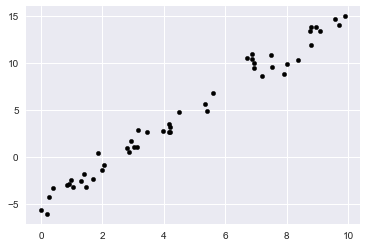

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2* x - 5 + rng.randn(50)
plt.scatter(x, y, s=20, c='black');

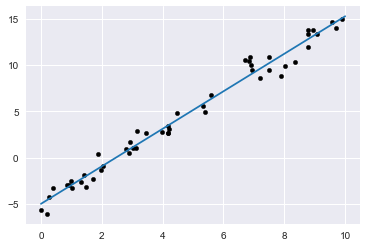

In [3]:
# fit the data
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s=20, c='black')
plt.plot(xfit, yfit);

In [4]:
print("Model slope:      ", model.coef_[0])
print("Model intercept: ", model.intercept_)

Model slope:       2.027208810360695
Model intercept:  -4.998577085553202


## Multivariate Regression

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2, 1.])

model.fit(X, y)
print("Model intercept: ", model.intercept_)
print("Model slope:      ", model.coef_)

Model intercept:  0.5000000000000127
Model slope:       [ 1.5 -2.   1. ]


# 2. Basis Function Regression

## Polynomial basis functions

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
# make 7th degree polynomial model using pipeline
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

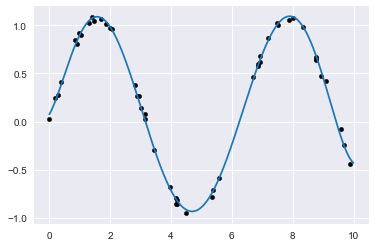

In [8]:
# fit sine wave with noise
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.rand(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s=20, c='black')
plt.plot(xfit, yfit);

## Gaussian basis functions

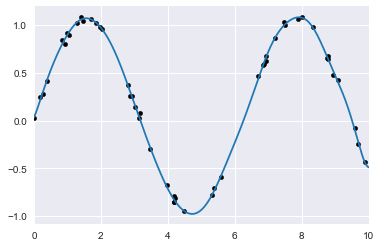

In [9]:
# custom function for Gaussian basis functions
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin): # inherit classes
    """Uniformly spaces Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0): # initialize instance
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod # like an instance method but not even tied to object. no reference to self
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis)) # like normal PDF
    
    def fit(self, X, y=None):
        # create N centres spread along the data range
        self.centres_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centres_[1] - self.centres_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centres_, 
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s=20, c='black')
plt.plot(xfit, yfit)
plt.xlim(0, 10);

# 3. Regularization

## Penalizing large values of the model parameters

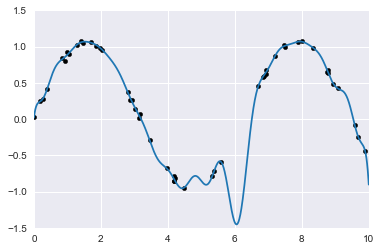

In [10]:
# example of overfitting if you choose 
# too many Gaussian basis functions
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y, s=20, c='black')
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

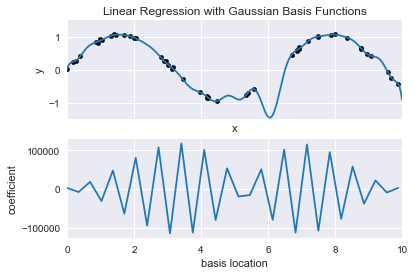

In [11]:
# see reason for overfitting if we plot coefficients of 
# Gaussian bases wrt their locations
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y, s=20, c='black')
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=[-1.5, 1.5])
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centres_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model, title="Linear Regression with Gaussian Basis Functions")

## Ridge Regression (L2 Regularization)

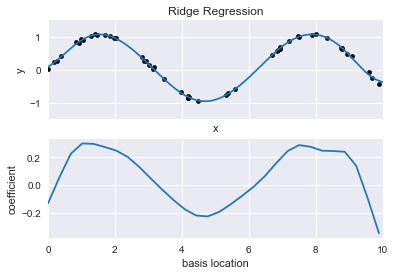

In [12]:
# penalizes sum  of squares of coefficients
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1)) # alpha controls strength of penalty
basis_plot(model, title='Ridge Regression')

## Lasso Regression (L1 Regularization)

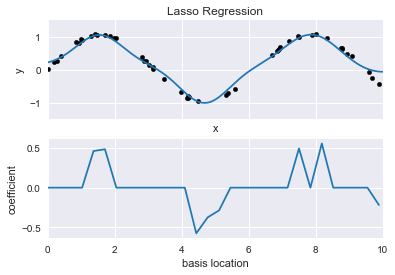

In [13]:
# penalizes sum  of absolute values of coefficients
# preference to sparse models where coefficients set to zero
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.01)) # alpha controls strength of penalty
basis_plot(model, title='Lasso Regression')

## Example: Predicting Bicycle Traffic

In [14]:
# download data with !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
import pandas as pd
counts = pd.read_csv('BicycleCounts.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('WeatherData.csv', index_col='DATE', parse_dates=True)

In [15]:
# compute total daily bike traffic
daily = counts.resample('D').sum()
daily['Total'] = daily.sum(axis=1) # add east and west sidewalks
daily = daily[['Total']] # remove other columns

In [16]:
# add binary columns for day of the week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# daily.index.dayofweek
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [17]:
# # CODE FOR CANADIAN HOLIDAYS
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install holidays

# from datetime import date 
# import holidays 

# # Select country 
# ca_holidays = holidays.Canada(years=[2019]) 
# ca_holidays.keys()
# #df_holidays = pd.DataFrame.from_dict(ca_holidays, orient='index')
# #df_holidays
# pd_date = pd.DatetimeIndex(ca_holidays.keys())
# pd_date

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2019')
# type(holidays)
# create holiday indicator variable and join to daily bike data
daily = daily.join(pd.Series(1, index=holidays, name='holiday')) # if holiday, code as 1
daily['holiday'].fillna(0, inplace=True) # if NaN, code as 0

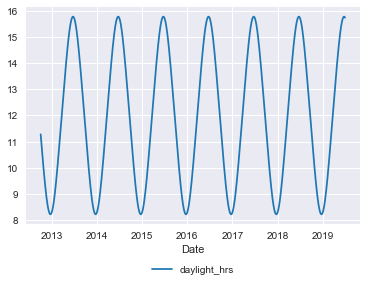

In [19]:
# add variable for hours of daylight

# create method that calculates hours of daylight 
# for given date that uses std. astronomial calculation

# DON'T EVEN BOTHER TRYING TO UNDERSTAND THIS
# HAS TO DO WITH SEATTLE'S COORDINATES AND
# THE EARTH'S AXIS TILT
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * 
         np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25))
        )
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
#date = pd.datetime(2019, 7, 8)
#hours_of_daylight(date)
daily[['daylight_hrs']].plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5);

In [20]:
# add weather data

# create avg temp (TMIN and TMAX are in F)
weather['TAVG'] = (weather['TMIN'] + weather['TMAX']) / 2

# create indicator for rain or not (PRCP is in inches)
weather['dry_day'] = (weather['PRCP']==0).astype(int)

# join weather to bike data
daily = daily.join(weather[['PRCP', 'TAVG', 'dry_day']])

In [21]:
# drop if weather data NA
daily = daily.dropna()

In [22]:
# create variable to measure how many years have passed
# like a time trend
daily['annual'] = (daily.index - daily.index[0]).days / 365
daily.tail()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,TAVG,dry_day,annual
Date,,,,,,,,,,,,,,
2019-06-21,4648.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.780240,0.0,63.0,1.0,6.717808
2019-06-22,2778.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.781095,0.0,60.5,1.0,6.720548
2019-06-23,1751.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.780582,0.0,60.0,1.0,6.723288
2019-06-24,4948.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.778702,0.0,61.5,1.0,6.726027
2019-06-25,6060.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.775456,0.0,63.0,1.0,6.728767


In [30]:
# IT'S MODEL TIME!

# drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

# choose X variables
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry_day', 'TAVG', 'annual']

X = daily[column_names]
y = daily['Total']

# tutorial says don't need intercept since we have day of week vars
# but I find that if you don't then coefs are weird
model = LinearRegression(fit_intercept=True) 
model.fit(X, y)
daily['predicted'] = model.predict(X)

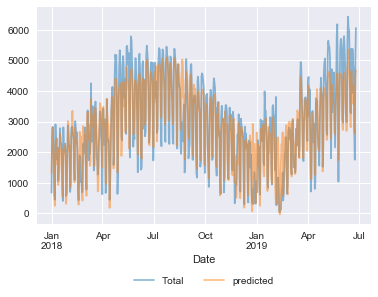

In [31]:
# compare total and predicted bike traffic

# plot only 2018-2019
mask = (daily.index > '12-31-2017')
df_2019 = daily.loc[mask]

df_2019[['Total', 'predicted']].plot(alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5);

In [36]:
# look at coefficients
params = pd.Series(model.coef_, index=X.columns)
params

Mon              533.238536
Tue              649.171640
Wed              622.430237
Thu              487.979046
Fri              162.242543
Sat            -1205.983975
Sun            -1249.078028
holiday        -1245.915525
daylight_hrs     105.674068
PRCP            -640.501447
dry_day          534.708292
TAVG              41.689266
annual            59.464324
dtype: float64

In [37]:
model.intercept_

-1220.240497488208

In [33]:
# get uncertainty of coefficients using bootstrap (resampling) method
from sklearn.utils import resample
np.random.seed(1991)
err = np.std([model.fit(*resample(X,y)).coef_
              for i in range(1000)], 0)

In [27]:
# X = daily[column_names]
# array2 = resample(X)
# array2

In [34]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            524.0   25.0
Tue            662.0   27.0
Wed            633.0   26.0
Thu            491.0   24.0
Fri            166.0   24.0
Sat          -1197.0   22.0
Sun          -1279.0   24.0
holiday      -1234.0  107.0
daylight_hrs   113.0    7.0
PRCP          -705.0   45.0
dry_day        512.0   24.0
TAVG            42.0    2.0
annual          54.0    6.0
